# Multi-Layer Perceptron, MNIST, Binarized

In [30]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [31]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

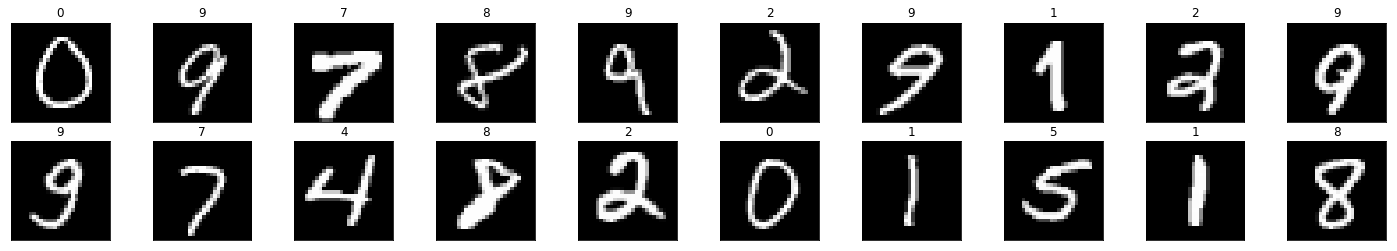

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

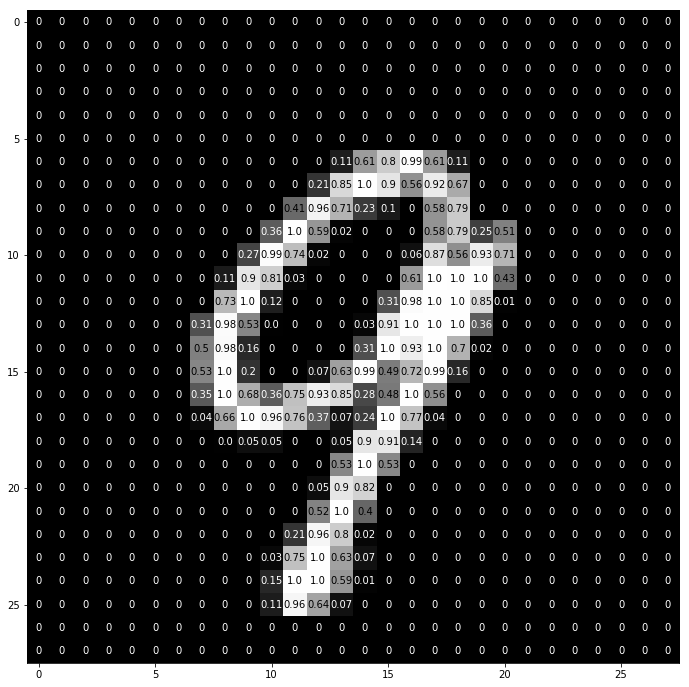

In [33]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Custom functions

In [34]:
import torch
import torch.nn as nn
from torch.autograd import Function

class BinarizeF(Function):

    @staticmethod
    def forward(cxt, input):
        output = input.new(input.size())
        output[input > 0] = 1
        output[input <= 0] = -1
        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input

# aliases
binarize = BinarizeF.apply

class BinaryLinear(nn.Linear):

    def forward(self, input):
        binary_weight = binarize(self.weight)
        if self.bias is None:
            return F.linear(input, binary_weight)
        else:
            return F.linear(input, binary_weight, self.bias)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = np.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv
        

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 32
        hidden_2 = 32
        self.fc1 = BinaryLinear(28 * 28, hidden_1, bias=False)
        self.fc2 = BinaryLinear(hidden_1, hidden_2, bias=False)
        self.fc3 = BinaryLinear(hidden_2, 10, bias=False)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = binarize(x)
        # add hidden layer, with relu activation function
        x = self.fc1(x)
        x = binarize(x)
        # add hidden layer, with relu activation function
        x = self.fc2(x)
        x = binarize(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): BinaryLinear(in_features=784, out_features=32, bias=False)
  (fc2): BinaryLinear(in_features=32, out_features=32, bias=False)
  (fc3): BinaryLinear(in_features=32, out_features=10, bias=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [36]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [37]:
def train_epoch(model, dataloader, criterion, optimizer, train_on_gpu):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        ## find the loss and update the model parameters accordingly
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # get the loss per batch and accumulate
        train_loss += loss.item()
        
        # get the class, highest probability
        probabilities = torch.exp(output)
        _, top_class = probabilities.topk(1, dim=1)
        # The following line is equivalent to the previous (?)
        #_, top_class = torch.max(probabilities, dim=1)
        
        # check if the predicted class is correct
        equals = top_class == target.view(*top_class.shape) # (batch_size x 1) 
        
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        '''## record the average training loss, using something like
        #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        train_accuracy = correct/ total'''
    
    
    print(train_accuracy / len(dataloader))
    return train_loss, train_accuracy


def validate_epoch(model, dataloader, criterion, train_on_gpu):
    valid_loss = 0.0
    valid_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            
            valid_loss += loss.item()

            ps = torch.exp(output)
            _ , top_class = ps.topk(1,dim = 1)
            #_, top_class = torch.max(ps, dim=1)
            equals = top_class == target.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            '''# average test loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            valid_accuracy = correct/ total'''
    
    return valid_loss, valid_accuracy

In [38]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    valid_losses = []
    train_losses = []
    valid_accuracies = []
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(n_epochs):
         # initialize variables to monitor training and validation loss
        training_loss = 0.0
        training_accuracy = 0.0
        
        ###################
        # train the model #
        model.train()
        training_loss, training_accuracy = train_epoch(model, loaders[0], criterion, optimizer, use_cuda)
    
        
        ######################    
        # validate the model #
        model.eval()
        validation_loss, validation_accuracy = validate_epoch(model, loaders[1], criterion, use_cuda)
        
        # calculate average loss 
        training_loss = training_loss/len(loaders[0])
        train_losses.append(training_loss)
        training_accuracy = training_accuracy/len(loaders[0])
        
        validation_loss = validation_loss/len(loaders[1])
        valid_losses.append(validation_loss)
        
        validation_accuracy = validation_accuracy/len(loaders[1])
        valid_accuracies.append(validation_accuracy)
        
        print('Epoch: {} \tTrain. Loss: {:.6f} \t Acc.: {:.6f}'
              ' \tValid. Loss: {:.6f} \t Acc.: {:.10f}'.format(
                  epoch,
                  training_loss,
                  training_accuracy, 
                  validation_loss,
                  validation_accuracy ))
        
        ###### save the model if validation loss has decreased
        if validation_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            validation_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = validation_loss

    
    return model

In [ ]:
# train the model
# For GPU training
# set model to model.cuda()
# set train_on_gpu to true

# For CPU training
# set model to model.cpu()
# set train_on_gpu to false

model_scratch = train(500, [train_loader, valid_loader], model.cpu(), optimizer, 
                      criterion, False, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

tensor(0.6491)
Epoch: 0 	Train. Loss: 2.106354 	 Acc.: 0.649104 	Valid. Loss: 1.741919 	 Acc.: 0.6949998140
Validation loss decreased (inf --> 1.741919).  Saving model ...
tensor(0.6649)
Epoch: 1 	Train. Loss: 2.012403 	 Acc.: 0.664896 	Valid. Loss: 1.728274 	 Acc.: 0.7015831470
Validation loss decreased (1.741919 --> 1.728274).  Saving model ...
tensor(0.6636)
Epoch: 2 	Train. Loss: 2.026962 	 Acc.: 0.663625 	Valid. Loss: 2.196295 	 Acc.: 0.6392499208
tensor(0.6764)
Epoch: 3 	Train. Loss: 1.919439 	 Acc.: 0.676438 	Valid. Loss: 1.735533 	 Acc.: 0.6615836024
tensor(0.6785)
Epoch: 4 	Train. Loss: 1.918123 	 Acc.: 0.678541 	Valid. Loss: 2.248997 	 Acc.: 0.5979166627
tensor(0.6818)
Epoch: 5 	Train. Loss: 1.919584 	 Acc.: 0.681834 	Valid. Loss: 1.933764 	 Acc.: 0.6716667414
tensor(0.6914)
Epoch: 6 	Train. Loss: 1.841926 	 Acc.: 0.691375 	Valid. Loss: 1.755737 	 Acc.: 0.7064166069
tensor(0.6926)
Epoch: 7 	Train. Loss: 1.864905 	 Acc.: 0.692625 	Valid. Loss: 1.959085 	 Acc.: 0.6737499237
ten

###  Load the Model with the Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load('model_scratch.pt'))

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [9]:
model = model.cpu()

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.357381

Test Accuracy of     0: 91% (893/980)
Test Accuracy of     1: 94% (1068/1135)
Test Accuracy of     2: 74% (764/1032)
Test Accuracy of     3: 76% (771/1010)
Test Accuracy of     4: 80% (794/982)
Test Accuracy of     5: 62% (557/892)
Test Accuracy of     6: 86% (828/958)
Test Accuracy of     7: 81% (837/1028)
Test Accuracy of     8: 80% (788/974)
Test Accuracy of     9: 59% (605/1009)

Test Accuracy (Overall): 79% (7905/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

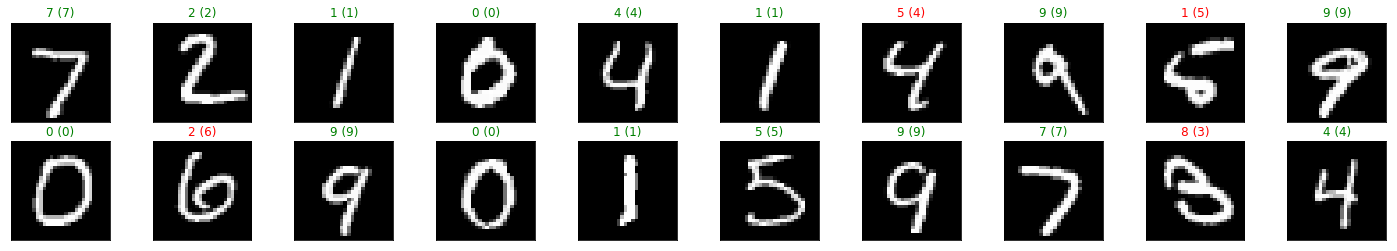

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Now export the weights!

In [14]:
weights = []
for i in range(3):
    weights.append(list(model.parameters())[i].data.numpy())

In [15]:
weights

[array([[ 0.00157564, -0.03139179, -0.01086011, ..., -0.03683886,
         -0.03611594, -0.00840505],
        [ 0.04964154,  0.06257517,  0.01185105, ...,  0.06586754,
          0.06650501,  0.0640031 ],
        [ 0.02108544,  0.0484759 , -0.00149455, ..., -0.01056301,
          0.02413636, -0.00495649],
        ...,
        [ 0.01559123,  0.04402907, -0.03407811, ...,  0.02011202,
          0.01590637, -0.02179987],
        [-0.00895489,  0.02314893,  0.06369948, ...,  0.06716961,
          0.04477068,  0.00117677],
        [ 0.00305751, -0.00346388,  0.02265295, ...,  0.0288602 ,
          0.04866853,  0.02125827]], dtype=float32),
 array([[ 2.66729277e-02, -1.22492778e+00,  2.23312354e+00, ...,
         -2.84066820e+00,  5.59450054e+00, -5.09243667e-01],
        [ 1.06415190e-02, -3.98202054e-02, -1.30087640e-02, ...,
          1.36342635e-02, -3.86190750e-02,  9.83525068e-03],
        [ 3.49057168e-01,  1.99538674e-02,  9.33037177e-02, ...,
         -5.88799238e-01, -2.06613466e-02

In [16]:
import pickle

pickle.dump(weights, open('weights.p', 'wb'))